In [135]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [136]:
def sentiment_transform(label):
    def func(series):
        return series.isin(label).sum() / series.count()
    return func

In [137]:
def prepare_data(ticker):
    stock_price = pd.read_csv(f"../dataset/stocks/{ticker}.csv")
    stock_price['time'] = pd.to_datetime(stock_price['time'])
    stock_price['trade_date'] = stock_price['time'].dt.date
    stock_price['delta'] = stock_price['close'].diff()
    stock_price['prv_close'] = stock_price['close'].shift(periods=1, fill_value=None)
    
    stock_news = pd.read_csv(f"../dataset/polygon_title_sentiment_3/{ticker}_title_sentiments.csv")
    stock_news['time'] = pd.to_datetime(stock_news['time'])
    stock_news['trade_date'] = (stock_news['time'] + pd.to_timedelta(0, unit='h')).dt.date

    stock_news['neg_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_score'] = 0.0
    stock_news['pos_score'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_score'] = 0.0
    stock_news['neg_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'negative', 'neg_mean'] = np.nan
    stock_news['pos_mean'] = stock_news['sentiment_score']
    stock_news.loc[stock_news['sentiment'] != 'positive', 'pos_mean'] = np.nan

    news_comb = pd.merge(stock_price, stock_news, how='left', on='trade_date')
    relation_gp = news_comb.groupby('trade_date').agg({
        'prv_close': 'first', 'delta': 'first', 'close': 'first', 'open': 'first', 'high': 'first', 'low': 'first',
        'sentiment': [sentiment_transform(['positive']), sentiment_transform(['negative'])], 
        'sentiment_score': 'mean', 'pos_score': 'mean', 'neg_score': 'mean', 'pos_mean': 'mean', 'neg_mean': 'mean'
    }).fillna(0.0).reset_index()
    relation_gp.columns = ['trade_date', 'prv_close', 'delta', 'close', 'open', 'high', 'low', 'positive', 'negative', 
                           'all_score', 'pos_score', 'neg_score', 'pos_mean', 'neg_mean']
    return relation_gp

In [138]:
relation_gp = prepare_data(ticker='AAPL')
relation_gp['all_score'].describe()

/var/folders/pj/znl5r0ln0hv_g1yjdthtr3f40000gn/T/ipykernel_1250/2186838793.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return series.isin(label).sum() / series.count()


count    502.000000
mean       0.063347
std        0.203172
min       -0.650344
25%       -0.051349
50%        0.056782
75%        0.185916
max        0.858853
Name: all_score, dtype: float64

In [139]:
def test_relevance(cols):
    X, y = relation_gp[cols], relation_gp['delta']
    model = LinearRegression()
    model.fit(X, y)

    # Make predictions
    y_pred = model.predict(X)

    # Evaluate the model
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, r2, model.coef_

In [140]:
test_relevance(['negative'])

(6.818201284096953, 0.02640880698933079, array([-3.21031719]))

In [141]:
test_relevance(['all_score']), 

((6.736621940179093, 0.03805776357781865, array([2.54353499])),)

In [142]:
test_relevance(['pos_score'])

(6.853155119499482, 0.02141764511365818, array([2.86719135]))

In [143]:
test_relevance(['neg_score'])

(6.799643484522392, 0.029058730257156884, array([3.87830153]))

In [144]:
test_relevance(['negative', 'neg_mean'])

(6.818157827214848, 0.02641501232647614, array([-3.17721773,  0.02711697]))

In [145]:
test_relevance(['positive', 'negative'])

(6.751657933019468, 0.035910729543827236, array([ 1.66057666, -2.52924482]))

In [146]:
test_relevance(['pos_score', 'neg_score'])

(6.729850348260034, 0.039024699281291375, array([2.05014963, 3.16447434]))

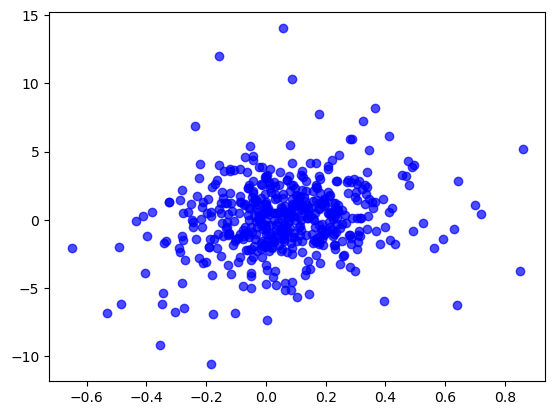

In [147]:
import matplotlib.pyplot as plt

plt.scatter(relation_gp['all_score'], relation_gp['delta'], color='blue', alpha=0.7)

In [ ]:
def preprocess(relation_gp, feat_cols):
    seq_length = 20
    std_scaler = StandardScaler()
    df = pd.DataFrame()
    df[feat_cols] = std_scaler.fit_transform(relation_gp[feat_cols])

    X = []
    y = []
    for i in range(seq_length, len(df)):
        X.append(df.iloc[i-seq_length:i])
        y.append(df.iloc[i, -1])
    X = torch.tensor(np.array(X)).type(torch.float32)
    y = torch.tensor(np.array(y)).type(torch.float32).unsqueeze(1) 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=67)
    # X_train = torch.tensor(X_train, dtype=torch.float32)
    # X_test = torch.tensor(X_test, dtype=torch.float32)
    # y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) 
    # y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1) 

    return X, y, X_train, X_test, y_train, y_test

In [149]:
class SimpleLSTM(nn.Module):
    def __init__(self, feat_size, layers, dropout):
        super(SimpleLSTM, self).__init__()
        self.fc1 = nn.Linear(feat_size[0], feat_size[1])
        self.lstm = nn.LSTM(feat_size[1], feat_size[2], num_layers=layers, dropout=dropout, batch_first=True)
        self.fc2 = nn.Linear(feat_size[2], feat_size[3])
    
    def forward(self, x):
        inp = self.fc1(x)
        lstm_out, (hn, cn) = self.lstm(inp)
        out = self.fc2(hn[-1])
        return out

In [ ]:
feat_cols = ['neg_score', 'close']
model = SimpleLSTM(feat_size=[len(feat_cols), 16, 64, 1], layers=2, dropout=0.5)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
X, y, X_train, X_test, y_train, y_test = preprocess(relation_gp, feat_cols)
X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([452, 50, 2]),
 torch.Size([452, 1]),
 torch.Size([429, 50, 2]),
 torch.Size([23, 50, 2]),
 torch.Size([429, 1]),
 torch.Size([23, 1]))

In [ ]:
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}")

Epoch 1, Train Loss: 0.8692, Test Loss: 0.9048
Epoch 2, Train Loss: 0.8378, Test Loss: 0.8716
Epoch 3, Train Loss: 0.8099, Test Loss: 0.8381
Epoch 4, Train Loss: 0.7781, Test Loss: 0.8030
Epoch 5, Train Loss: 0.7473, Test Loss: 0.7654
Epoch 6, Train Loss: 0.7129, Test Loss: 0.7243
Epoch 7, Train Loss: 0.6770, Test Loss: 0.6787
Epoch 8, Train Loss: 0.6332, Test Loss: 0.6277
Epoch 9, Train Loss: 0.5857, Test Loss: 0.5705
Epoch 10, Train Loss: 0.5361, Test Loss: 0.5067
Epoch 11, Train Loss: 0.4818, Test Loss: 0.4369
Epoch 12, Train Loss: 0.4177, Test Loss: 0.3627
Epoch 13, Train Loss: 0.3545, Test Loss: 0.2879
Epoch 14, Train Loss: 0.2890, Test Loss: 0.2183
Epoch 15, Train Loss: 0.2254, Test Loss: 0.1613
Epoch 16, Train Loss: 0.1754, Test Loss: 0.1230
Epoch 17, Train Loss: 0.1421, Test Loss: 0.1066
Epoch 18, Train Loss: 0.1255, Test Loss: 0.1137
Epoch 19, Train Loss: 0.1278, Test Loss: 0.1387
Epoch 20, Train Loss: 0.1521, Test Loss: 0.1577
Epoch 21, Train Loss: 0.1728, Test Loss: 0.1540
E

In [152]:
model.eval()

with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    std = y_test.std()
    print(f'Test Loss: {loss.item():.4f}')
    print(f'Std: {std:.4f}')
    print(f'Error Range: {loss.sqrt() / std:.4f}')

Test Loss: 0.0071
Std: 0.9528
Error Range: 0.0884


In [153]:
def visualize(pred, ref, limit=1000):
    time = np.arange(len(pred))

    plt.plot(time[:limit], pred[:limit], label='Predicted Price', color='blue')
    plt.plot(time[:limit], ref[:limit], label='Real Price', color='orange')
    plt.xlabel('Trade Day')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

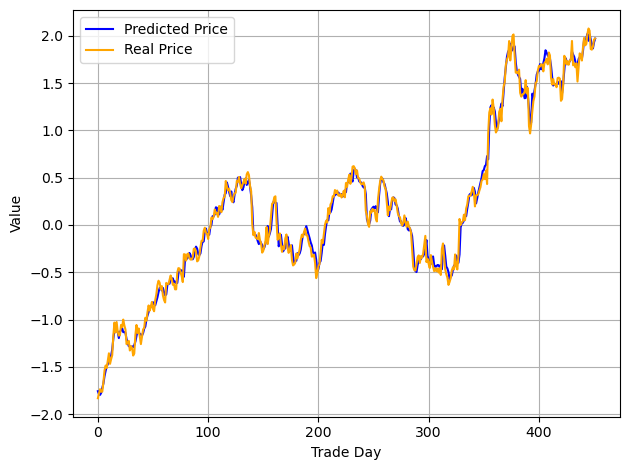

In [154]:
with torch.no_grad():   
    y_pred = model(X)
visualize(y_pred, y)

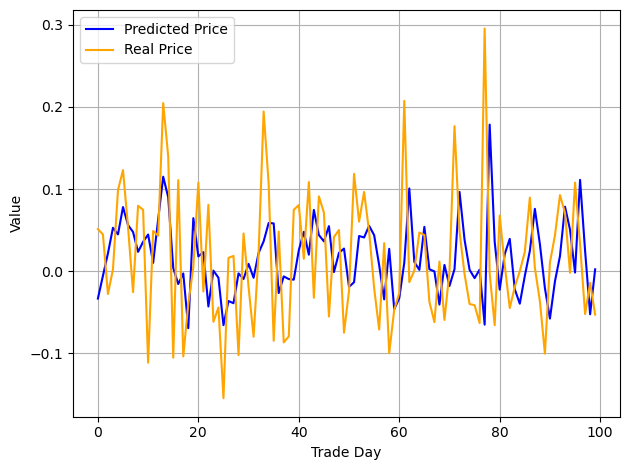

array([[1.        , 0.22261322],
       [0.22261322, 1.        ]])

In [155]:
y_pred_diff = y_pred.squeeze().diff()
y_diff = y.squeeze().diff()
visualize(y_pred_diff, y_diff, 100)
np.corrcoef(y_pred_diff, y_diff)

In [156]:
aveg_error = np.abs(y_pred - y).mean()
aveg_delta = np.abs(y.squeeze().diff()).mean()
aveg_error, aveg_delta

(tensor(0.0607), tensor(0.0717))